# 2024 NeurIPS - MyoChallenge

## <center> Welcome to the [**2024 NeurIPS - MyoChallenge:  Physiological Dexterity and Agility in Enhanced Humans**](https://sites.google.com/view/myosuite/myochallenge/myochallenge-2024) </center>



In this tutorial, we will show you how to load the latest MyoSuite baseline.

> Authors: Cheryl Wang (huiyi.wang@mail.mcgill.ca)

Note:


1.   The baseline is trained with PPO - stablebaseline3, you can only load it when using this library.
2.   This baseline method uses a hard-coded method for prosthesis (MPL), and a curriculum based training for the myoArm.





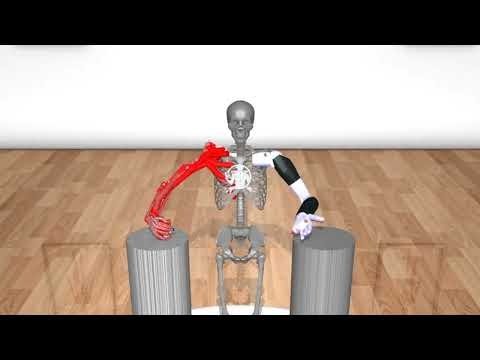

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('332TcmMUABA')

## 1. Setting the environment


In [2]:
!pip install myosuite==2.8.3
!pip install "stable-baselines3[extra]"  --quiet
!pip install tqdm  --quiet
!pip install mujoco==3.1.2
!pip install sk-video
%env MUJOCO_GL=egl
import mujoco

env: MUJOCO_GL=egl


libEGL warning: failed to open /dev/dri/renderD128: Permission denied

libEGL warning: NEEDS EXTENSION: falling back to kms_swrast


## Define a method to show the rendering inside the Colab

In [3]:
from IPython.display import HTML
from base64 import b64encode

def show_video(video_path, video_width = 400):

  video_file = open(video_path, "r+b").read()

  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"""<video autoplay width={video_width} controls><source src="{video_url}"></video>""")

## All the `MyoSuite` imports needed to run this tutorial

In [4]:
import myosuite
from myosuite.utils import gym
import skvideo.io
import numpy as np
import os
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import CheckpointCallback
# from tqdm import tqdm_notebook as tqdm
from tqdm.notebook import tqdm

pygame 2.6.1 (SDL 2.28.4, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


/home/ta747375ki/myochallenge-neuroflex/venv/lib/python3.10/site-packages/gymnasium/envs/registration.py:596: UserWarning: WARN: plugin: shimmy.registration:register_gymnasium_envs raised Traceback (most recent call last):
  File "/home/ta747375ki/myochallenge-neuroflex/venv/lib/python3.10/site-packages/gymnasium/envs/registration.py", line 594, in load_plugin_envs
    fn()
  File "/home/ta747375ki/myochallenge-neuroflex/venv/lib/python3.10/site-packages/shimmy/registration.py", line 303, in register_gymnasium_envs
    _register_dm_control_envs()
  File "/home/ta747375ki/myochallenge-neuroflex/venv/lib/python3.10/site-packages/shimmy/registration.py", line 63, in _register_dm_control_envs
    from shimmy.dm_control_compatibility import DmControlCompatibilityV0
  File "/home/ta747375ki/myochallenge-neuroflex/venv/lib/python3.10/site-packages/shimmy/dm_control_compatibility.py", line 20, in <module>
    from gymnasium.envs.mujoco.mujoco_rendering import MujocoRenderer
  File "/home/ta747

MyoSuite:> Registering Myo Envs


## Download the latest baseline from Google Drive

In [5]:
!pip install wget
import wget

In [6]:
# Importing necessary library
import os

file_id = '168S3oTBmXuf23zDDGMM3tCJ3HBnjYhsM'
download_url = f'https://drive.google.com/uc?export=download&id={file_id}'
target_file = 'baseline.zip'  # Change the file name and extension as needed
# target_file = ROOT_DIR + 'baseline.zip'  # Change the file name and extension as needed

# Using wget to download the file
os.system(f'wget --no-check-certificate "{download_url}" -O {target_file}')

# Check if the file is downloaded
if os.path.exists(target_file):
    print(f'Successfully downloaded {target_file}')
else:
    print('Failed to download the file')

--2024-11-16 14:25:22--  https://drive.google.com/uc?export=download&id=168S3oTBmXuf23zDDGMM3tCJ3HBnjYhsM
Resolving drive.google.com (drive.google.com)... 172.217.161.78, 2404:6800:4004:81f::200e
Connecting to drive.google.com (drive.google.com)|172.217.161.78|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=168S3oTBmXuf23zDDGMM3tCJ3HBnjYhsM&export=download [following]
--2024-11-16 14:25:22--  https://drive.usercontent.google.com/download?id=168S3oTBmXuf23zDDGMM3tCJ3HBnjYhsM&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.222.1, 2404:6800:4004:80f::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.222.1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3167662 (3.0M) [application/octet-stream]
Saving to: ‘baseline.zip’

     0K .......... .......... .......... .......... ..........  1% 1.63M 2s
 

Successfully downloaded baseline.zip


.... .......... 84% 9.05M 0s
  2600K .......... .......... .......... .......... .......... 85% 9.28M 0s
  2650K .......... .......... .......... .......... .......... 87% 7.91M 0s
  2700K .......... .......... .......... .......... .......... 88% 8.57M 0s
  2750K .......... .......... .......... .......... .......... 90% 9.02M 0s
  2800K .......... .......... .......... .......... .......... 92% 9.22M 0s
  2850K .......... .......... .......... .......... .......... 93% 7.35M 0s
  2900K .......... .......... .......... .......... .......... 95% 12.8M 0s
  2950K .......... .......... .......... .......... .......... 96% 7.75M 0s
  3000K .......... .......... .......... .......... .......... 98% 6.82M 0s
  3050K .......... .......... .......... .......... ...       100% 21.8M=0.4s

2024-11-16 14:25:28 (7.02 MB/s) - ‘baseline.zip’ saved [3167662/3167662]



## Starting the Manipulation Env and Loading the Baseline

**The rendering of the policy would likely take a few minutes. Please be patient :)**



In [7]:
env_name = 'myoChallengeBimanual-v0'
env = gym.make(env_name)

    MyoSuite: A contact-rich simulation suite for musculoskeletal motor control
        Vittorio Caggiano, Huawei Wang, Guillaume Durandau, Massimo Sartori, Vikash Kumar
        L4DC-2019 | https://sites.google.com/view/myosuite
    


/home/ta747375ki/myochallenge-neuroflex/venv/lib/python3.10/site-packages/myosuite/envs/myo/myochallenge/bimanual_v0.py:432: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.manip_joint_range = np.arange(model.joint("manip_object/freejoint").qposadr,
/home/ta747375ki/myochallenge-neuroflex/venv/lib/python3.10/site-packages/myosuite/envs/myo/myochallenge/bimanual_v0.py:432: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.manip_joint_range = np.arange(model.joint("manip_object/freejoint").qposadr,
/home/ta747375ki/myochallenge-neuroflex/venv/lib/python3.10/site-packages/myosuite/envs/myo/myochallenge/bimanual_v0.py:432: DeprecationWarn

In [8]:
checkpoint_callback = CheckpointCallback(save_freq=1000, save_path='./logs/', name_prefix='ppo_model')
model = PPO.load('baseline', env)
env.reset()
env.seed(51) #setting a seed for the env
tb_log_name = "ppo_training"
model.learn(total_timesteps=5000, callback=checkpoint_callback, tb_log_name=tb_log_name)
# model = PPO.load("./src/logs/ppo_model_6000_steps.zip", env)

/home/ta747375ki/myochallenge-neuroflex/venv/lib/python3.10/site-packages/stable_baselines3/common/save_util.py:165: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  deserialized_object = cloudpickle.loads(base64_object)
/home/ta747375ki/myochallenge-neuroflex/venv/lib/python3.10/site-packages/stable_baselines3/common/save_util.py:165: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discourag

In [21]:
model = PPO.load("./logs/ppo_model_6000_steps.zip", env, device='cpu')  # Load model on CPU


In [24]:
# Ignore specific warning
import warnings
warnings.filterwarnings("ignore", message=".*tostring.*is deprecated.*")

movie = True #we want to save a video
frames = []
view = 'front'
for _ in range(2):
    ep_rewards = []
    done = False
    obs = env.reset()
    for step in range(500):
        if done: break
        obs = env.obsdict2obsvec(env.obs_dict, env.obs_keys)[1]
        action, _ = model.predict(obs, deterministic=True)
        # hard-coding the myoHand to release object
        action[30] = 1
        if step > 130:
    #   if obs.
            action[32:40] = 0
            action[40:49] = 1

        #hard coding the MPL to the desire position, since we know the actuation of the MPL is the last 17 index of action
        action[-17:] = np.array([-0.65001469 , 1.     ,    -0.23187843 , 0.59583695 , 0.92356688, -0.16,
                                -0.28 ,      -0.88   ,     0.25 ,      -0.846   ,   -0.24981132 ,-0.91823529,
                                -0.945  ,    -0.925   ,   -0.929   ,   -0.49    ,   -0.18      ])
        if step > 250:
            action[-17:] = np.array([-0.4199236 ,  1.      ,   -0.9840558 ,  0.35299219,  0.92356688,  0.02095238,
                                        -0.28    ,   -0.88  ,      0.25      , -0.846     , -0.24981132, -0.91823529,
                                        -0.945   ,   -0.925   ,   -0.929    ,  -0.49     ,  -0.918     ])
        if step > 350:
            action[-17:] = np.array([-0.4199236 ,  1.     ,    -0.9840558,   0.35299219 , 0.3910828 ,  0.02095238,
                                        -0.28    ,   -0.88     ,   0.25   ,    -0.846     , -0.24981132 ,-0.91823529,
                                        -0.945    ,  -0.925    ,  -0.929    ,  -0.49  ,     -0.918     ])

        obs, reward, done, info, info_2 = env.step(action)
        if movie:
            geom_1_indices = np.where(env.sim.model.geom_group == 1)
            env.sim.model.geom_rgba[geom_1_indices, 3] = 0
            frame = env.sim.renderer.render_offscreen(width= 400, height=400,camera_id=1)
            frames.append(frame)

env.close()

os.makedirs('videos', exist_ok=True)
# make a local copy
skvideo.io.vwrite('videos/test_policy1.mp4', np.asarray(frames), inputdict = {'-r': '100'}, outputdict={"-pix_fmt": "yuv420p"})
show_video('videos/test_policy1.mp4')

/home/ta747375ki/myochallenge-neuroflex/venv/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.obsdict2obsvec to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.obsdict2obsvec` for environment variables or `env.get_wrapper_attr('obsdict2obsvec')` that will search the reminding wrappers.
  logger.warn(
/home/ta747375ki/myochallenge-neuroflex/venv/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.obs_dict to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.obs_dict` for environment variables or `env.get_wrapper_attr('obs_dict')` that will search the reminding wrappers.
  logger.warn(
/home/ta747375ki/myochallenge-neuroflex/venv/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.obs_keys to get variables from other wrappers is deprecated and will be removed in v1.0, t

FileNotFoundError: [Errno 2] No such file or directory: 'videos/test_policy1.mp4'

You will first notice that only in some occasion the myoHand is grasping the object. This is because the baseline is trained upon simple no variation conditions. To fully replicate the baseline behavior, initiate the env with no variations:


```
kwargs={
            'model_path': curr_dir + '/../assets/arm/myoarm_bionic_bimanual.xml',
            'normalize_act': True,
            'frame_skip': 5,
            'obj_scale_change': None
            'obj_mass_change': None
            'obj_friction_change': None
        }
```

!Note: The evaluation env will still have variations

## With all of those set, you can fully replicate the new baseline solution and build on top of it. Happy training!